# Libraries

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for the models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


# misc
import warnings
warnings.filterwarnings(action="ignore")
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

## Get new clean data

In [2]:
train = pd.read_csv("./train_final.csv")
test = pd.read_csv("./test_final.csv")

train_dummies = pd.read_csv("./train_dummies_final.csv")
test_dummies = pd.read_csv("./test_dummies_final.csv")

## Target Variable 

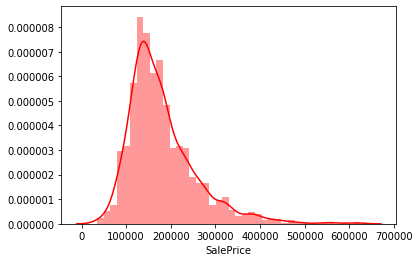

In [3]:
# our target variable is SalePrice
sns.distplot(train['SalePrice'], color='Red');

The target variable is <b>skewed right</b>. We should use a power transformation to make it evenly distributed. Powers < 1 are good for transforming data that is skewed right. This will be done in feature engineering.

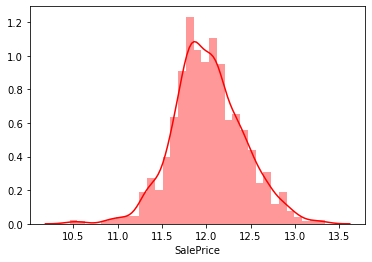

In [4]:
train["SalePrice"] = np.log(train["SalePrice"])
train_dummies["SalePrice"] = np.log(train_dummies["SalePrice"])
sns.distplot(train['SalePrice'], color='Red');

## Modeling

In [5]:
# feature scaling
#scaler = StandardScaler()
#train_columns = train.columns
#train = pd.DataFrame(scaler.fit_transform(train), columns = train_columns)

# separate predictors and prediction
y = train_dummies["SalePrice"]
X = train_dummies.drop("SalePrice", axis=1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)

# k-folds
kfold = KFold(n_splits=10, random_state=0, shuffle=True)

# functions for error score
def cv_rmsle(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfold))
    return (rmse)

# alphas for Ridge and Lasso
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

# df with each score to make a comparison plot later
d = {'Model': [], 'Score': []}
model_scores_df = pd.DataFrame(data=d)

##### Multiple Linear Regression

In [77]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R^2 for train_split set: %f" %lm.score(X_train, y_train))
print("R^2 for test_split  set: %f" %lm.score(X_test, y_test))
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(lm.predict(X_test), y_test)))

R^2 for train_split set: 0.932744
R^2 for test_split  set: 0.914361
RMSLE for test_split  set: 0.008784


##### Ridge

In [63]:
print('-'*15, 'Alpha = 1', '-'*15)
ridge = Ridge(alpha=1).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge.score(X_train, y_train))) 
print("Test set score: {:.5f}".format(ridge.score(X_test, y_test)))
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(ridge.predict(X_test), y_test)))

print()
print('-'*15, 'Alpha = 10', '-'*15)

ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge10.score(X_train, y_train))) 
print("Test set score: {:.5f}".format(ridge10.score(X_test, y_test)))
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(ridge10.predict(X_test), y_test)))

print()
print('-'*15, 'Alpha = 0.1', '-'*15)

ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge01.score(X_train, y_train))) 
print("Test set score: {:.5f}".format(ridge01.score(X_test, y_test)))
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(ridge01.predict(X_test), y_test)))


--------------- Alpha = 1 ---------------
Training set score: 0.93088
Test set score: 0.92027
RMSLE for test_split  set: 0.008473

--------------- Alpha = 10 ---------------
Training set score: 0.92371
Test set score: 0.92030
RMSLE for test_split  set: 0.008467

--------------- Alpha = 0.1 ---------------
Training set score: 0.93259
Test set score: 0.91793
RMSLE for test_split  set: 0.008598


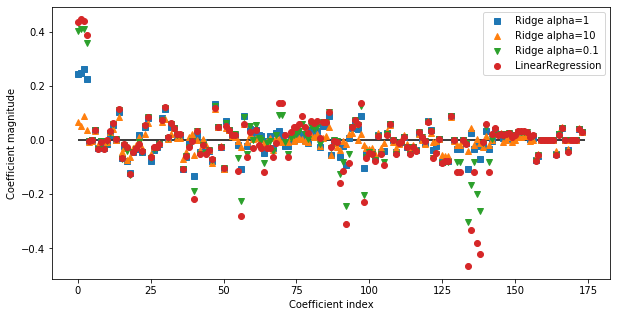

In [73]:
plt.plot(ridge.coef_, 's', label="Ridge alpha=1") 
plt.plot(ridge10.coef_, '^', label="Ridge alpha=10") 
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")
plt.plot(lm.coef_, 'o', label="LinearRegression") 
plt.xlabel("Coefficient index") 
plt.ylabel("Coefficient magnitude") 
plt.hlines(0, 0, len(lm.coef_)) 
plt.legend();

##### Lasso

In [69]:
print('-'*15, 'Alpha = 0.01', '-'*15)

lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train) 
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train))) 
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test))) 
print("Number of features used: {}".format(np.sum(lasso001.coef_ != 0)))
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(lasso001.predict(X_test), y_test)))

print()
print('-'*15, 'Alpha = 0.001', '-'*15)

lasso0001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train) 
print("Training set score: {:.2f}".format(lasso00001.score(X_train, y_train))) 
print("Test set score: {:.2f}".format(lasso00001.score(X_test, y_test))) 
print("Number of features used: {}".format(np.sum(lasso00001.coef_ != 0)))
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(lasso0001.predict(X_test), y_test)))

print()
print('-'*15, 'Alpha = 0.0001', '-'*15)

lasso00001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train) 
print("Training set score: {:.2f}".format(lasso00001.score(X_train, y_train))) 
print("Test set score: {:.2f}".format(lasso00001.score(X_test, y_test))) 
print("Number of features used: {}".format(np.sum(lasso00001.coef_ != 0)))
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(lasso00001.predict(X_test), y_test)))

--------------- Alpha = 0.01 ---------------
Training set score: 0.83
Test set score: 0.84
Number of features used: 23
RMSLE for test_split  set: 0.012073

--------------- Alpha = 0.001 ---------------
Training set score: 0.93
Test set score: 0.92
Number of features used: 146
RMSLE for test_split  set: 0.008373

--------------- Alpha = 0.0001 ---------------
Training set score: 0.93
Test set score: 0.92
Number of features used: 146
RMSLE for test_split  set: 0.008373


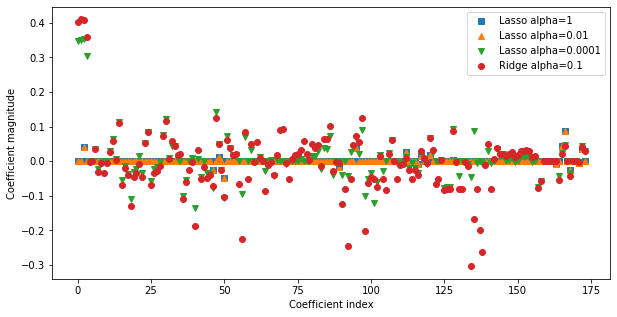

In [75]:
plt.plot(lasso.coef_, 's', label="Lasso alpha=1") 
plt.plot(lasso001.coef_, '^', label="Lasso alpha=0.01") 
plt.plot(lasso00001.coef_, 'v', label="Lasso alpha=0.0001")
plt.plot(ridge01.coef_, 'o', label="Ridge alpha=0.1") 
plt.legend()
plt.xlabel("Coefficient index") 
plt.ylabel("Coefficient magnitude");

##### ElasticNet

In [80]:
print('-'*15, 'normalize=False', '-'*15)

elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5, normalize=False)
elasticnet.fit(X, y)
print(r'The R^2 !normalized is %.2f' %(elasticnet.score(X, y)))
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(elasticnet.predict(X_test), y_test)))

print()
print('-'*15, 'normalize=True', '-'*15)

elasticnetNorm = ElasticNet(alpha=0.1, l1_ratio=0.5, normalize=True)
elasticnetNorm.fit(X, y)
print(r'The R^2 normalized is %.2f' %(elasticnetNorm.score(X, y)))
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(elasticnetNorm.predict(X_test), y_test)))

--------------- normalize=False ---------------
The R^2 !normalized is 0.72
RMSLE for test_split  set: 0.015616

--------------- normalize=True ---------------
The R^2 normalized is 0.00
RMSLE for test_split  set: 0.029747


#### Gradient Boosting Regressor

In [85]:
gbm = GradientBoostingRegressor().fit(X_train, y_train)
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(gbm.predict(X_test), y_test)))

RMSLE for test_split  set: 0.008456


##### LightGBM

In [82]:
lightgbm = LGBMRegressor(objective='regression').fit(X_train, y_train)
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(lightgbm.predict(X_test), y_test)))

# insert into model_scores_df
model_scores_df = model_scores_df.append({'Model': 'LightGBM', 'Score': score.mean()}, ignore_index=True)

RMSLE for test_split  set: 0.008562


#### XGBoost

In [86]:
xgboost = XGBRegressor().fit(X_train, y_train)
print("RMSLE for test_split  set: %f" %np.sqrt(mean_squared_log_error(xgboost.predict(X_test), y_test)))


# insert into model_scores_df
model_scores_df = model_scores_df.append({'Model': 'XGBoost', 'Score': score.mean()}, ignore_index=True)

RMSLE for test_split  set: 0.010103


#### Comparison

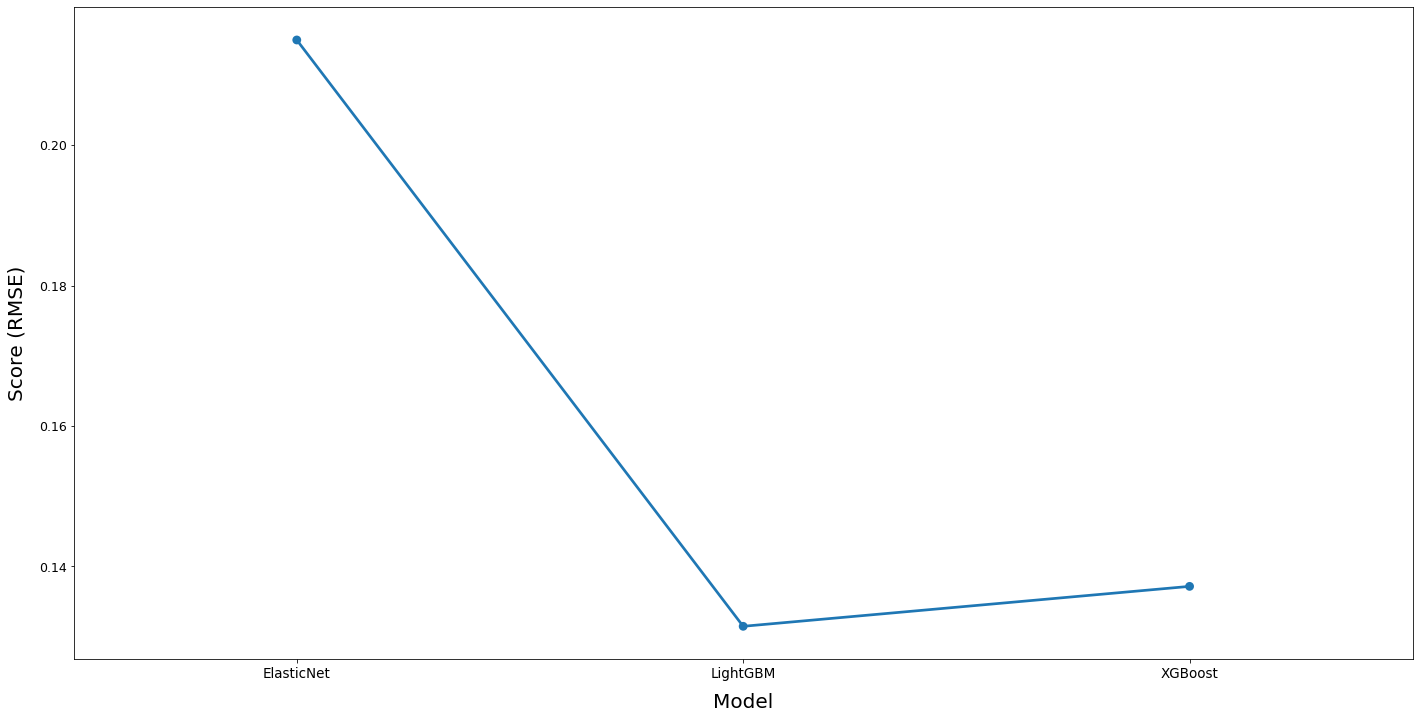

In [18]:
# Plot the predictions for each model
fig = plt.figure(figsize=(24, 12))
ax = sns.pointplot(x='Model', y='Score', data=model_scores_df)

plt.ylabel('RMSE', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.show()